In [3]:
# Import libraries
import os
import time
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import r2_score, confusion_matrix, classification_report, roc_curve
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
import warnings
warnings.filterwarnings("ignore")
plt.style.use('seaborn-notebook')
sns.set_style('darkgrid')
# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

In [4]:
# load data
df = pd.read_csv('../data/diabetic_data_processed.csv', na_values='?')

# examine first 5 rows of dataframe
print(f'Shape of diabetic data: {df.shape}\n')
display(df.head())

Shape of diabetic data: (69990, 86)



,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,...,mean_diagnoses,min_diagnoses,max_diagnoses,unique_glu_measurements,avg_times_glu_high,num_times_glu_high,glu_always_high,glu_ever_high,unique_a1c_results,avg_times_a1c_high,num_times_a1c_high,a1c_always_high,a1c_ever_high,avg_times_med_changed,num_times_med_changed,med_always_changed,med_ever_changed,avg_times_diabetic_med_prescribed,num_times_diabetic_med_prescribed,diabetic_med_always_prescribed,diabetic_med_ever_prescribed,avg_times_readmitted,num_times_readmitted,always_readmitted,ever_readmitted
0,135,Caucasian,Female,[50-60),Emergency,Home,Emergency Room,3,UNK,Other,31,1,14,0,0,1,injury,other,neoplasms,5,UNK,UNK,Steady,No,No,...,6.5,5,8,1,0.0,0,0,0,1,0.0,0,0,0,1.0,2,1,1,1.0,2,1,1,0.5,1,0,1
1,378,Caucasian,Female,[50-60),Elective,Home,Physician Referral,2,UNK,Other,49,1,11,0,0,0,musculoskeletal,other,neoplasms,3,UNK,UNK,No,No,No,...,3.0,3,3,1,0.0,0,0,0,1,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0
2,729,Caucasian,Female,[80-100),Emergency,SNF,Emergency Room,4,MC,InternalMedicine,68,2,23,0,0,0,injury,respiratory,Einjury,9,UNK,>7,Steady,No,No,...,9.0,9,9,1,0.0,0,0,0,1,0.0,0,0,0,0.0,0,0,0,1.0,1,1,1,0.0,0,0,0
3,774,Caucasian,Female,[80-100),Emergency,Home,Emergency Room,3,UNK,InternalMedicine,46,0,20,0,0,0,neoplasms,other,other,9,UNK,>8,Steady,No,No,...,9.0,9,9,1,0.0,0,0,0,1,1.0,1,1,1,1.0,1,1,1,1.0,1,1,1,0.0,0,0,0
4,927,AfricanAmerican,Female,[0-50),Emergency,Home,Emergency Room,5,UNK,InternalMedicine,49,0,5,0,0,0,genitournary,neoplasms,neoplasms,3,UNK,UNK,No,No,No,...,3.0,3,3,1,0.0,0,0,0,1,0.0,0,0,0,0.0,0,0,0,1.0,1,1,1,0.0,0,0,0


### Checking correlation between the float columns and readmission.

In [5]:
int_columns=df.select_dtypes(['int']).drop('patient_nbr', axis=1).columns

# Initialize lists to store the results
cor_list = []
col_list = []

# Loop through each column in the integer columns list
for col in int_columns:
    col_list.append(col)
    # Compute correlation between the column and 'readmitted'
    cor_value = np.corrcoef(df[col], df['readmitted'])[0, 1]
    cor_list.append(cor_value)

# Create a DataFrame with the results
correlation_df = pd.DataFrame({
    'Column': col_list,
    'CorrelationWithReadmitted': cor_list
})

# Now you can print or display the DataFrame
correlation_df.sort_values('CorrelationWithReadmitted', ascending=False)


,Column,CorrelationWithReadmitted
10,readmitted,1.000e+00
37,always_readmitted,8.430e-01
38,ever_readmitted,6.020e-01
36,num_times_readmitted,4.610e-01
6,number_inpatient,1.386e-01
11,num_encounters,6.806e-02
13,max_time_in_hospital,6.643e-02
33,num_times_diabetic_med_prescribed,6.481e-02
15,max_num_lab_procedures,6.457e-02
21,max_diagnoses,5.977e-02


### Checking corelation between the X variables

In [6]:
# Set your threshold
upper_threshold = 0.99
lower_threshold=0.5

# Calculate the correlation matrix
int_df = df.select_dtypes(include=['int', 'int64'])
corr_matrix = int_df.corr()

# Apply the threshold to the correlation matrix and find pairs with high correlation
high_corr_pairs = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                   .stack()
                   .reset_index())
high_corr_pairs.columns = ['col1', 'col2', 'corr_value']

# Filter out the pairs with correlation above the threshold
high_corr_pairs = high_corr_pairs[(high_corr_pairs['corr_value'] > lower_threshold )& (high_corr_pairs['corr_value'] < upper_threshold ) ]
high_corr_pairs.sort_values('corr_value',ascending=False)


,col1,col2,corr_value
297,number_diagnoses,max_diagnoses,0.952
370,diabetesMed,diabetic_med_ever_prescribed,0.927
715,num_times_a1c_high,a1c_ever_high,0.924
127,num_procedures,min_num_procedures,0.921
369,diabetesMed,diabetic_med_always_prescribed,0.920
338,change,med_ever_changed,0.915
165,num_medications,max_num_medications,0.913
337,change,med_always_changed,0.910
296,number_diagnoses,min_diagnoses,0.908
90,num_lab_procedures,max_num_lab_procedures,0.907


### Plotting class imbalance

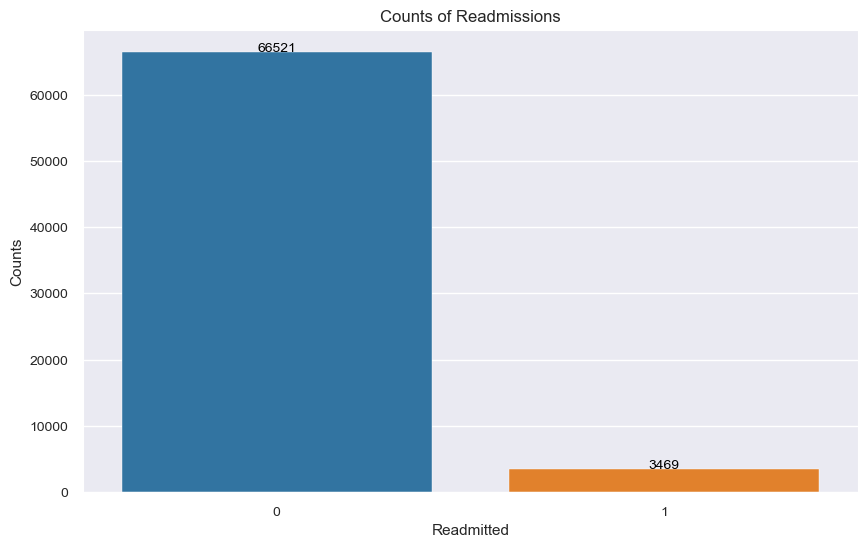

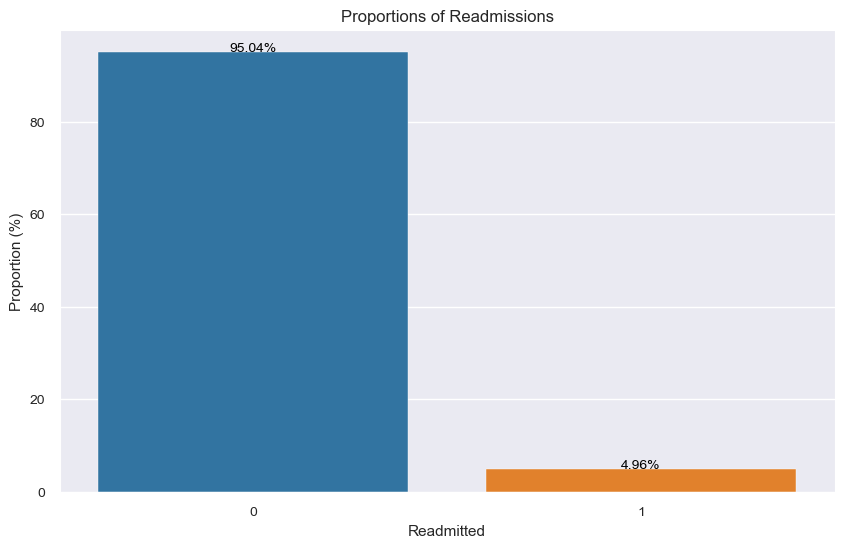

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate counts
value_counts = df['readmitted'].value_counts()

# Calculate proportions
proportions = df['readmitted'].value_counts(normalize=True) * 100

# Create a DataFrame from the counts and proportions
data_to_plot = pd.DataFrame({'Counts': value_counts, 'Proportions': proportions})

# Plot a bar graph using the counts
plt.figure(figsize=(10, 6))

# Create a bar plot for the counts
count_plot = sns.barplot(x=data_to_plot.index, y=data_to_plot['Counts'])

# Annotate each bar with the count value
for index, value in enumerate(data_to_plot['Counts']):
    count_plot.text(index, value, f'{value}', color='black', ha="center")

plt.title('Counts of Readmissions')
plt.xlabel('Readmitted')
plt.ylabel('Counts')
plt.show()

# Plot a bar graph using the proportions
plt.figure(figsize=(10, 6))

# Create a bar plot for the proportions
prop_plot = sns.barplot(x=data_to_plot.index, y=data_to_plot['Proportions'])

# Annotate each bar with the proportion value
for index, value in enumerate(data_to_plot['Proportions']):
    prop_plot.text(index, value, f'{value:.2f}%', color='black', ha="center")

plt.title('Proportions of Readmissions')
plt.xlabel('Readmitted')
plt.ylabel('Proportion (%)')
plt.show()
